# Context
The data was collected from an apartment unit in San Jose for one plus year of one of Kaggle's community members. The collection was done with smart meters and shared by his energy company. This is time-series data by nature and can be used for various time-series Machine Learning experiments.

## Description of Data
The data contains eight attributes.

- TYPE - This is an information column. The value is 'Electric usage' for all the observations.
- DATE - Date of electric consumption. There is no timestamp in this field.
- START TIME - Start time of the consumption.
- END TIME - End time of the consumption
- USAGE - Consumption in kWh
- UNITS - This column denotes measurement unit. It is kWh for all the observations.
- COST - Cost of consumption in $.
- NOTES - Mostly an empty column

# Environment 

In [1]:
#setting environment 
import pandas as pd
import numpy as np
''' Data visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config

set_config(display='diagram')
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.metrics import confusion_matrix
''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# EDA

In [3]:
data= pd.read_csv("../IOTTimeSeries/Data/D202.csv", parse_dates=True)
data.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB


In [5]:
data.duplicated().sum()

0

In [6]:
data.isnull().sum()

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64

In [7]:
print(data.head())
print(data.columns)

             TYPE        DATE START TIME END TIME  USAGE UNITS    COST  NOTES
0  Electric usage  10/22/2016       0:00     0:14   0.01   kWh  $0.00     NaN
1  Electric usage  10/22/2016       0:15     0:29   0.01   kWh  $0.00     NaN
2  Electric usage  10/22/2016       0:30     0:44   0.01   kWh  $0.00     NaN
3  Electric usage  10/22/2016       0:45     0:59   0.01   kWh  $0.00     NaN
4  Electric usage  10/22/2016       1:00     1:14   0.01   kWh  $0.00     NaN
Index(['TYPE', 'DATE', 'START TIME', 'END TIME', 'USAGE', 'UNITS', 'COST',
       'NOTES'],
      dtype='object')


In [8]:
#converting date column to datetime object
data['DATE']= pd.to_datetime(data.DATE)
data.columns=data.columns.str.lower()
data.head()

,type,date,start time,end time,usage,units,cost,notes
0,Electric usage,2016-10-22,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,2016-10-22,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,2016-10-22,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,2016-10-22,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,2016-10-22,1:00,1:14,0.01,kWh,$0.00,NaN


In [9]:
#getting daily freq
res = data.groupby('date')['usage'].nunique()
res= res.to_frame()
res

,usage
date,
2016-10-22,9
2016-10-23,17
2016-10-24,12
2016-10-25,13
2016-10-26,8
...,...
2018-10-20,8
2018-10-21,4
2018-10-22,3


<AxesSubplot:xlabel='date'>

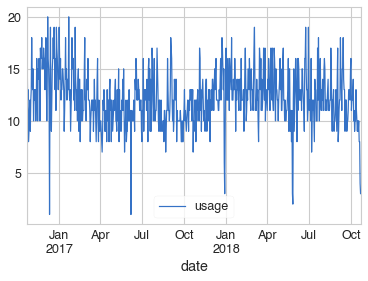

In [10]:
#plot data 
res.plot()

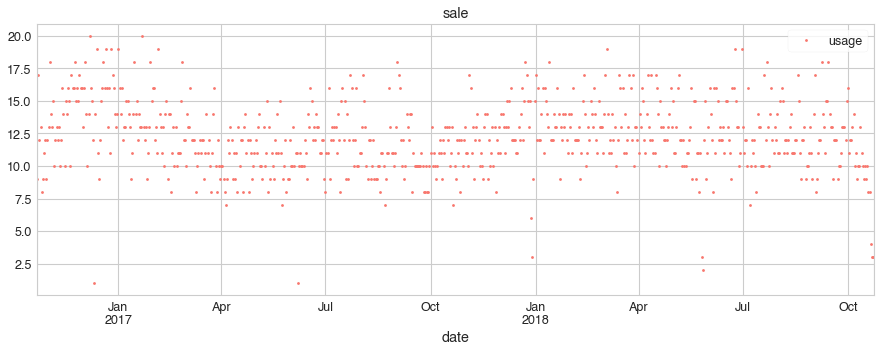

In [11]:
color_pal = ["#F8766D", "#D39200",
             "#93AA00", "#00BA38",
             "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
_ = res.plot(style='.',
             figsize=(15,5),
             color=color_pal[0],
             title='sale')

In [12]:
#data conversions
print(res.index.max())
print(res.index.min())

2018-10-24 00:00:00
2016-10-22 00:00:00


# XGBoost

In [13]:
# data split
split_date = '2018-01-01'
train= res.loc[res.index <= split_date].copy()
test= res.loc[res.index > split_date].copy()

In [14]:
print(train.shape, test.shape)

(437, 1) (296, 1)


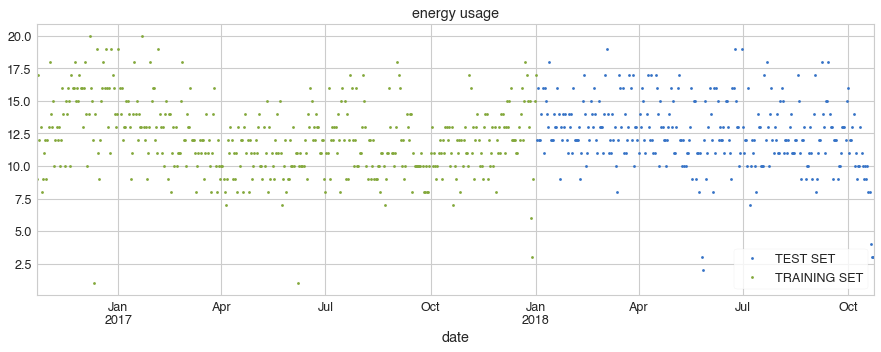

In [15]:
#plot train and test density plot 
_ = test \
    .rename(columns={'usage': 'TEST SET'}) \
    .join(train.rename(columns={'usage': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='energy usage', style='.')

## features engineering

In [16]:
# feature creation from ds 
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [17]:
X_train, y_train = create_features(train, label='usage')
X_test, y_test = create_features(test, label='usage')
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2016-10-22,0,5,4,10,2016,296,22,42
2016-10-23,0,6,4,10,2016,297,23,42
2016-10-24,0,0,4,10,2016,298,24,43
2016-10-25,0,1,4,10,2016,299,25,43
2016-10-26,0,2,4,10,2016,300,26,43
...,...,...,...,...,...,...,...,...
2017-12-28,0,3,4,12,2017,362,28,52
2017-12-29,0,4,4,12,2017,363,29,52
2017-12-30,0,5,4,12,2017,364,30,52


In [18]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(437, 8) (296, 8) (437,) (296,)


## Model 

In [20]:
#import xgboost 
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

#instantiate
xgb = xgb.XGBRegressor(n_estimators=1000)

#fitting
xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=30,
       verbose=True)

[0]	validation_0-rmse:8.55258	validation_1-rmse:9.03593
[1]	validation_0-rmse:6.25056	validation_1-rmse:6.81588
[2]	validation_0-rmse:4.65518	validation_1-rmse:5.39709
[3]	validation_0-rmse:3.55001	validation_1-rmse:4.46932
[4]	validation_0-rmse:2.80352	validation_1-rmse:3.86294
[5]	validation_0-rmse:2.30685	validation_1-rmse:3.52733
[6]	validation_0-rmse:2.00648	validation_1-rmse:3.31095
[7]	validation_0-rmse:1.79905	validation_1-rmse:3.16667
[8]	validation_0-rmse:1.66287	validation_1-rmse:3.07480
[9]	validation_0-rmse:1.55426	validation_1-rmse:3.02910
[10]	validation_0-rmse:1.48836	validation_1-rmse:3.01574
[11]	validation_0-rmse:1.42794	validation_1-rmse:3.02058
[12]	validation_0-rmse:1.35736	validation_1-rmse:3.00587
[13]	validation_0-rmse:1.31721	validation_1-rmse:3.01231
[14]	validation_0-rmse:1.27803	validation_1-rmse:3.01378
[15]	validation_0-rmse:1.24035	validation_1-rmse:3.01318
[16]	validation_0-rmse:1.22229	validation_1-rmse:3.02109
[17]	validation_0-rmse:1.14893	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Features importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

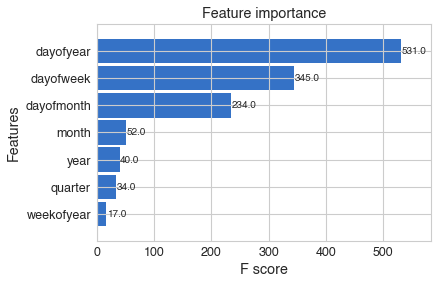

In [21]:
#feature selection
plot_importance(xgb, height= 0.9)

## Forecasting on test set 

<AxesSubplot:xlabel='date'>

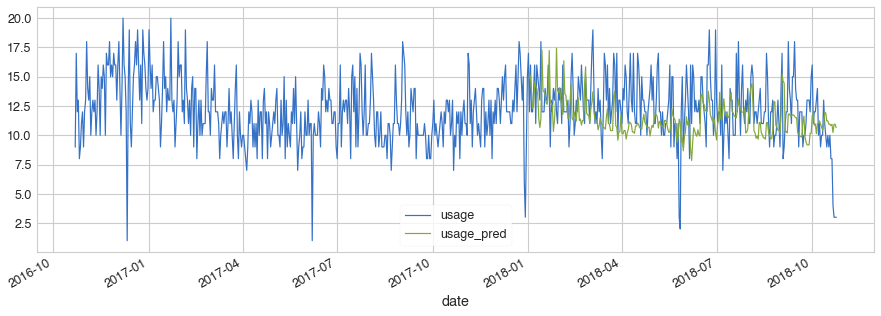

In [22]:
#forecasting
test['usage_pred']= xgb.predict(X_test)
data_all = pd.concat([test, train], sort=False)

#plot
data_all[['usage','usage_pred']].plot(figsize=(15, 5))

## Error metrics

In [23]:
#errors
#mse
print('rmse score is: ', np.sqrt(mean_squared_error(y_true=test['usage'],
                   y_pred=test['usage_pred'])))

#mae
print('mae score is: ', mean_absolute_error(y_true=test['usage'],
                   y_pred=test['usage_pred']))
      
# mean absolute percent error because it gives an easy way to interperate percentage showing how off the predictions are. 
# MAPE isn't included in sklearn so we need to use a custom function.
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('mape score is ',mean_absolute_percentage_error(y_true=test['usage'],
                   y_pred=test['usage_pred']))

print('mean:', y_test.mean())

rmse score is:  3.005872754637811
mae score is:  2.3666275610794894
mape score is  22.676708442248714
mean: 12.43918918918919


We see that the RMSE is quite low compared to the mean (9% of the size of the mean overall), which means that XGBoost did quite a good job at predicting the values of the test set.

## Worst and Best predicted days 

In [25]:
# worst predicted day 
test['error'] = test['usage'] - test['usage_pred']
test['abs_error'] = test['error'].apply(np.abs)
error_by_day = test.groupby(['year','month','dayofmonth']) \
    .mean()[['usage','usage_pred','error','abs_error']]

# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

usage  usage_pred     error  abs_error
year month dayofmonth                                        
2018 5     27            2.0   11.106812 -9.106812   9.106812
           26            3.0   11.373481 -8.373481   8.373481
     10    22            3.0   10.941949 -7.941949   7.941949
           23            3.0   10.941949 -7.941949   7.941949
           24            3.0   10.662539 -7.662539   7.662539
     9     3             8.0   14.609943 -6.609943   6.609943
     10    21            4.0   10.232221 -6.232221   6.232221
     9     4             9.0   14.468779 -5.468779   5.468779
     1     28           12.0   17.439327 -5.439327   5.439327
           14           12.0   17.276054 -5.276054   5.276054

In [26]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

usage  usage_pred     error  abs_error
year month dayofmonth                                        
2018 5     27            2.0   11.106812 -9.106812   9.106812
     6     30           19.0   10.222401  8.777599   8.777599
     5     26            3.0   11.373481 -8.373481   8.373481
     10    23            3.0   10.941949 -7.941949   7.941949
           22            3.0   10.941949 -7.941949   7.941949
           24            3.0   10.662539 -7.662539   7.662539
     6     6            16.0    8.819135  7.180865   7.180865
     4     12           17.0   10.286831  6.713169   6.713169
     9     3             8.0   14.609943 -6.609943   6.609943
     6     8            16.0    9.396789  6.603211   6.603211

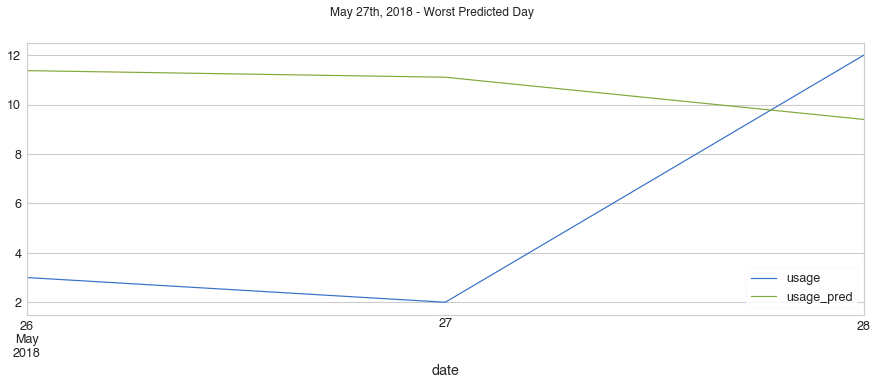

In [29]:
#plotof the worst predicted day
_ = data_all["2018-05-26":"2018-05-28"][['usage','usage_pred']].plot(figsize=(15, 5),
                                              style=['-','-'])
plot = plt.suptitle('May 27th, 2018 - Worst Predicted Day')


In [30]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

usage  usage_pred     error  abs_error
year month dayofmonth                                        
2018 7     27           12.0   11.983238  0.016762   0.016762
     3     1            11.0   11.028106 -0.028106   0.028106
     5     14           11.0   11.030883 -0.030883   0.030883
     7     9            12.0   12.032393 -0.032393   0.032393
           2            11.0   11.049782 -0.049782   0.049782
     3     19           11.0   11.061200 -0.061200   0.061200
     9     24           10.0    9.861597  0.138403   0.138403
     3     8            11.0   11.189339 -0.189339   0.189339
     7     21           12.0   12.207019 -0.207019   0.207019
     4     15           11.0   10.785243  0.214757   0.214757

# Conclusion
Our model captures pretty well training time series info and does a good job forecasting on the test set. 
- one further step would be to try out fitting the model on selected features. As we saw earlier, the week/year/ & quarter features don't hold much variance into explaining the energy usage. 
- do some hyperparameter tuning to better off our model's performance 